In [1]:
# to access functions from root directory
import sys
sys.path.append('/data/ad181/RemoteDir/multilevel_ppo')

In [2]:
%matplotlib notebook
import os
import pickle
import numpy as np 
import matplotlib.pyplot as plt  
from itertools import product
from matplotlib.lines import Line2D
from tqdm import trange
import functools
from time import time, sleep
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

from utils.env_evaluate_functions import eval_actions
from utils.plot_functions import plot_s_snapshots, plot_k_array
from utils.clustering_functions import get_connectivity_dist_mat

from stable_baselines3.common.envs.multi_level_model.ressim import Grid
from stable_baselines3.common.envs.multi_level_model.k_distributions import batch_generate_krige
from stable_baselines3.common.envs.multi_level_ressim_env import RessimParams, RessimEnvParamGenerator, MultiLevelRessimEnv

In [3]:
seed=1

env_dir = './env_data_v1'
os.makedirs(env_dir, exist_ok=True)

In [4]:
# domain properties
nx = 73
ny = 219
lx = 620*0.3048 #620 ft
ly = 1820*0.3048 #1820 ft
grid = Grid(nx=nx, ny=ny, lx=lx, ly=ly)

phi = 0.2*np.ones(grid.shape)
s_wir = 0.0
s_oir = 0.0

# fluid properties
mu_w = 3e-4 # 0.3 cp
mu_o = mu_w
mobility='linear'

# time steps
dt = 1
nstep = 5
terminal_step= 5 # total: 25 days

# initial conditions
ooip = grid.lx * grid.ly * phi[0,0] * (1 - s_wir - s_oir) # original oil in place
total_time = nstep*terminal_step*dt
fraction = 1.0
Q = fraction*ooip/total_time 
q = np.zeros(grid.shape)
q[1::36, 36] = Q/7
q[1::36, 0] = -Q/14
q[1::36, -1] = -Q/14
s = np.ones(grid.shape)*s_wir

<IPython.core.display.Javascript object>


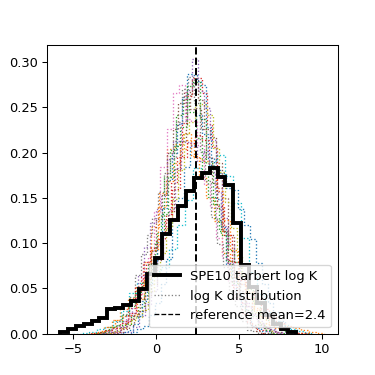

In [5]:
# uncertainty distribution
k = np.loadtxt(f'/data/ad181/RemoteDir/multilevel_ppo/spe10_ref_case/spe10_data/tarbert_perm.csv', delimiter=',') 
m2_md_conv = 1.01325e+15
k = m2_md_conv*k
tarbert_log_mean = np.mean(np.log(k))
step_x, step_y = lx/(nx-1), ly/(ny-1)
cond_pos_ = np.where(np.abs(q) > 0.0) 
cond_pos = np.array([cond_pos_[0]*step_y, cond_pos_[1]*step_x])
n_wells = cond_pos[0].shape[0]
cond_val = [tarbert_log_mean]*n_wells

# training samples
k_train = batch_generate_krige(nx=nx, ny=ny, lx=lx, ly=ly,
                               variance=5,
                               len_scale=[0.1*lx, 1.0*lx],
                               cond_pos=cond_pos,
                               cond_val=cond_val,
                               angle=np.pi/8,
                               n_samples=16,
                               seed=seed)

# evaluation samples
k_eval = batch_generate_krige(nx=nx, ny=ny, lx=lx, ly=ly,
                               variance=5,
                               len_scale=[0.1*lx, 1.0*lx],
                               cond_pos=cond_pos,
                               cond_val=cond_val,
                               angle=np.pi/8,
                               n_samples=16,
                               seed=17)


# plotting superposition of k_train and tarbert k distribution
fig, axs = plt.subplots(1,1, figsize=(4,4) )
for i,k_log in enumerate(k_train):
    axs.hist(k_log.flatten(), density=True, histtype='step', bins=30, linestyle='dotted')
axs.hist(np.log(k.flatten()), density=True, histtype='step', bins=30, linestyle='solid', linewidth=3, color='black')
axs.axvline(tarbert_log_mean, linestyle='dashed', color='black')
custom_lines = [Line2D([0], [0], color='black', lw=3),
                Line2D([0], [0], color='gray', lw=1, linestyle='dotted'),
                Line2D([0], [0], color='black', lw=1, linestyle='dashed')]
axs.legend(custom_lines, ['SPE10 tarbert log K', 'log K distribution', f'reference mean={round(tarbert_log_mean,1)}'], loc='lower right')
fig.show()

<IPython.core.display.Javascript object>


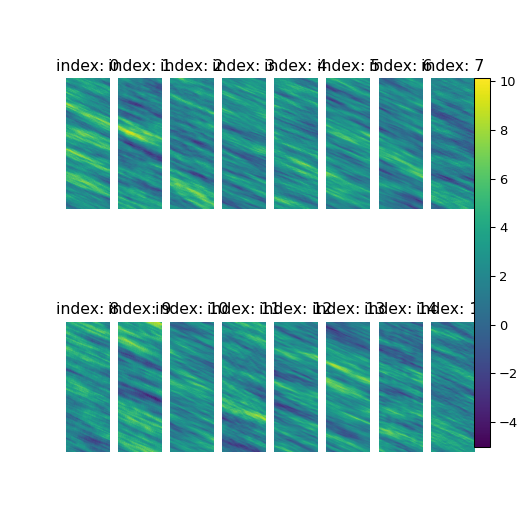

<IPython.core.display.Javascript object>


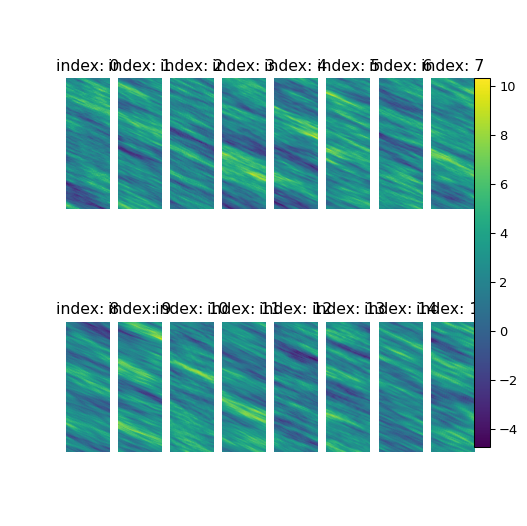

In [6]:
fig = plot_k_array(k_train,q=None, cols=8, rows=2)
fig = plot_k_array(k_eval,q=None, cols=8, rows=2)

In [7]:
# unit conversion 
md_m2_conv = 1/1.01325e+15
k_train = md_m2_conv*np.exp(k_train) 
k_eval = md_m2_conv*np.exp(k_eval)  

### generate dummy environement

In [8]:
level_dict = {1:[9,27], 2:[19,57], 3:[37, 111], 4:[73,219]}
level=4

ressim_params = RessimParams(grid, np.exp(k_train), phi, s_wir, s_oir, 
                             mu_w, mu_o, mobility, 
                             dt, nstep, terminal_step, 
                             q, s, level_dict)
params_generator = RessimEnvParamGenerator(ressim_params)
gen_ressim_params = params_generator.get_level_env_params(level)
env = MultiLevelRessimEnv(gen_ressim_params, level)

/data/ad181/RemoteDir/multilevel_ppo/stable_baselines_mlppo/stable_baselines3/common/envs/multi_level_model/level_mapping_functions.py:51: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for j in range(len(p_1)-1):


### generate clustered samples

compute connectivity distances...


  0%|          | 0/300 [00:00<?, ?it/s]

form distance matrix...


0it [00:00, ?it/s]

<IPython.core.display.Javascript object>


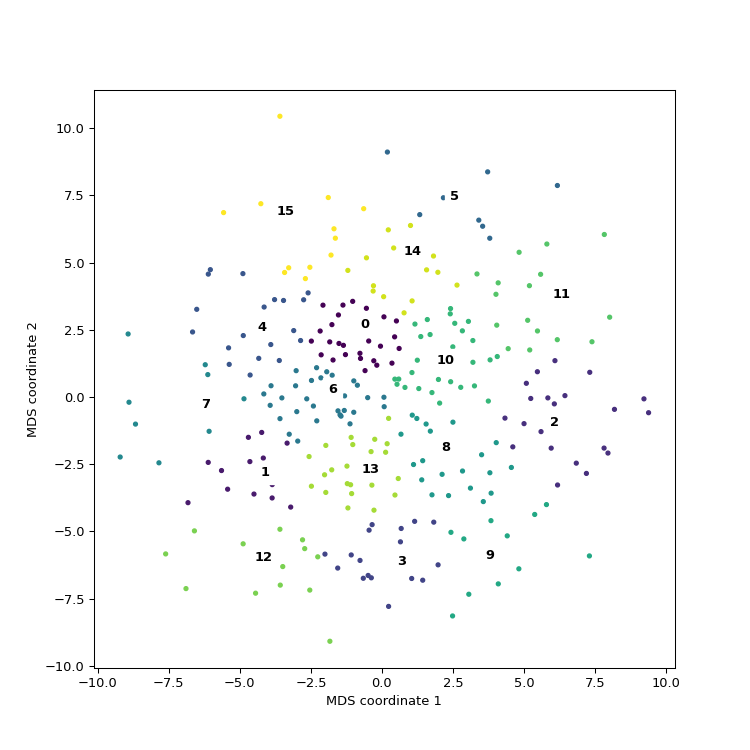

In [9]:
# generate N=1000 samples of the uncertainty distribution
n_samples=300
k_samples_md = batch_generate_krige(nx=nx, ny=ny, lx=lx, ly=ly,
                                    variance=5,
                                    len_scale=[0.1*lx, 1.0*lx],
                                    cond_pos=cond_pos,
                                    cond_val=cond_val,
                                    angle=np.pi/8,
                                    n_samples=n_samples,
                                    seed=33)

md_m2_conv = 1/1.01325e+15
k_samples = md_m2_conv*np.exp(k_samples_md) 

# locations x'' in equation 7
list_x, list_y = list(range(env.grid.nx)), list(range(env.grid.ny))
x,y = np.meshgrid(list_x[::72], list_y[1::18])
y_loc, x_loc = x.ravel(), y.ravel()

# generate the clustering using MDS data
dist_matrix = get_connectivity_dist_mat(k_samples, env, x_loc, y_loc)
embedding = MDS(n_components=2, dissimilarity='precomputed', random_state=seed)
X_transformed = embedding.fit_transform(dist_matrix)

# number of clusters l=16
clusters = 16
km = KMeans(n_clusters=clusters, random_state=seed)
y_pred = km.fit_predict(X_transformed)
closest, _ = pairwise_distances_argmin_min(km.cluster_centers_, X_transformed)

# visualize clusters
plt.figure(figsize=(8,8))
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y_pred, marker='.')
for i, idx in enumerate(closest):
    plt.text(X_transformed[idx, 0], X_transformed[idx, 1], str(i), backgroundcolor='white', fontweight='bold')
plt.xlabel('MDS coordinate 1')
plt.ylabel('MDS coordinate 2')
plt.show()

### generate clustered training and evaluation samples

In [10]:
# training samples chosen from cluster centers
k_train_clustered = k_samples_md[closest]

# evaluations samples chosen randomly from each cluster
labels = km.labels_
k_clusters = []
for n in range(clusters):
    indices = np.where(labels==n)[0]
    ks = []
    for ind in indices:
        ks.append(k_samples_md[ind])
    k_clusters.append(ks)

k_eval_clustered = []
for k in k_clusters:
    mid_ind=int(len(k)/2) # choose k which is in the middle of each cluster array, for reproducibility
    k_eval_clustered.append(k[mid_ind])
k_eval_clustered = np.array(k_eval_clustered)


# save clustered samples
np.save(env_dir+'/k_log_md_train_clustered.npy', k_train_clustered)
np.save(env_dir+'/k_log_md_eval_clustered.npy', k_eval_clustered)

<IPython.core.display.Javascript object>


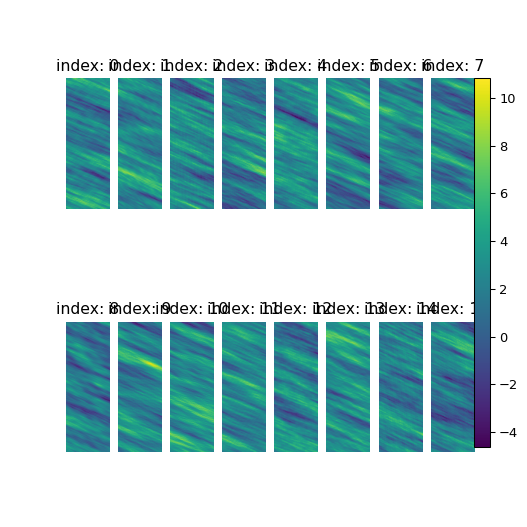

<IPython.core.display.Javascript object>


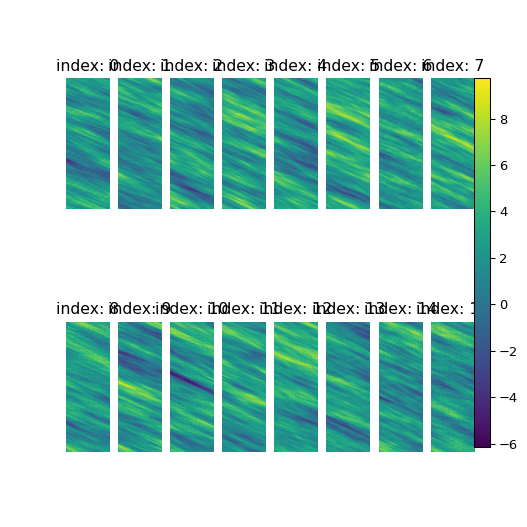

In [11]:
fig = plot_k_array(k_train_clustered,q=None, cols=8, rows=2)
fig = plot_k_array(k_eval_clustered,q=None, cols=8, rows=2)

# Generate multilevel environment dictionaries

In [12]:
# k_train_clustered = md_m2_conv*np.exp(k_train_clustered)
# k_eval_clustered = md_m2_conv*np.exp(k_eval_clustered)

In [13]:
# from stable_baselines3.common.envs.multi_level_model.level_mapping_functions import coarse_to_fine_mapping, get_partition_ind, fine_to_coarse_mapping

# level_dict = {1:[9,27], 2:[19,57], 3:[37, 111], 4:[73,219]}

# fig, ax = plt.subplots(1,1)
# k = k_train_clustered[0]
# ax.imshow(k)
# fig.show()

# for level in range(3,4):
#     partition_ind = get_partition_ind(level_dict[4][0], level_dict[4][1], level_dict[level][0], level_dict[level][1])
#     print(partition_ind)
#     k_ = fine_to_coarse_mapping(k, partition_ind, func='hmean')
#     fig, ax = plt.subplots(1,1)
#     ax.imshow(k_)
#     fig.show()

In [14]:
k_train_clustered = md_m2_conv*np.exp(k_train_clustered)
k_eval_clustered = md_m2_conv*np.exp(k_eval_clustered)

level_dict = {1:[9,27], 2:[19,57], 3:[37, 111], 4:[73,219]}

ressim_params_train = RessimParams(grid, k_train_clustered, phi, s_wir, s_oir, 
                                   mu_w, mu_o, mobility, 
                                   dt, nstep, terminal_step, 
                                   q, s, level_dict)
train_params_generator = RessimEnvParamGenerator(ressim_params_train)

ressim_params_eval = RessimParams(grid, k_eval_clustered, phi, s_wir, s_oir, 
                                  mu_w, mu_o, mobility, 
                                  dt, nstep, terminal_step, 
                                  q, s, level_dict)
eval_params_generator = RessimEnvParamGenerator(ressim_params_eval)

env_train_dict = {}
env_eval_dict = {}

for level in level_dict.keys():
    print('level: ', level)
    
    gen_train_ressim_params = train_params_generator.get_level_env_params(level)
    env_train_dict[level] = MultiLevelRessimEnv(gen_train_ressim_params, level)
    env_train_dict[level].seed(seed)
    
    gen_eval_ressim_params = eval_params_generator.get_level_env_params(level)
    env_eval_dict[level] = MultiLevelRessimEnv(gen_eval_ressim_params, level)
    env_eval_dict[level].seed(seed)

    
# save environment dictionaries
with open(env_dir+'/env_train_dict.pkl', 'wb') as output:
    pickle.dump(env_train_dict, output, pickle.HIGHEST_PROTOCOL)
    
with open(env_dir+'/env_eval_dict.pkl', 'wb') as output:
    pickle.dump(env_eval_dict, output, pickle.HIGHEST_PROTOCOL) 

level:  1
level:  2
level:  3
level:  4


# Generate single permeability environment for MLMC anlaysis

In [15]:
level = len(level_dict)
ressim_params_ck = RessimParams(grid, np.array( [k_train_clustered[10]] ), phi, s_wir, s_oir, 
                             mu_w, mu_o, mobility, 
                             dt, nstep, terminal_step, 
                             q, s, level_dict)
params_generator_ck = RessimEnvParamGenerator(ressim_params_ck)
gen_ressim_params_ck = params_generator_ck.get_level_env_params(level)
env_ck = MultiLevelRessimEnv(gen_ressim_params_ck, level)
env_ck.seed(seed)

# save fine level single perm env 
with open(env_dir+'/env_ck.pkl', 'wb') as output:
    pickle.dump(env_ck, output, pickle.HIGHEST_PROTOCOL) 
    

env_ck_dict = {}
for level in level_dict.keys():
    gen_ressim_params_ck = params_generator_ck.get_level_env_params(level)
    env_ck_dict[level] = MultiLevelRessimEnv(gen_ressim_params_ck, level)
    env_ck_dict[level].seed(seed)
    
# save single permeability environment dictionary
with open(env_dir+'/env_ck_dict.pkl', 'wb') as output:
    pickle.dump(env_ck_dict, output, pickle.HIGHEST_PROTOCOL)

# Simulation runs

level: 1, grid: [9, 27]
simulation time: 0 seconds


<IPython.core.display.Javascript object>


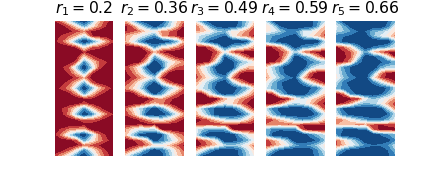

level: 2, grid: [19, 57]
simulation time: 0 seconds


<IPython.core.display.Javascript object>


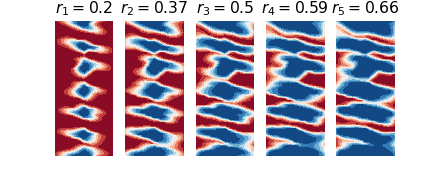

level: 3, grid: [37, 111]
simulation time: 0 seconds


<IPython.core.display.Javascript object>


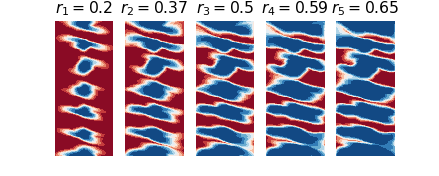

level: 4, grid: [73, 219]
simulation time: 1 seconds


<IPython.core.display.Javascript object>


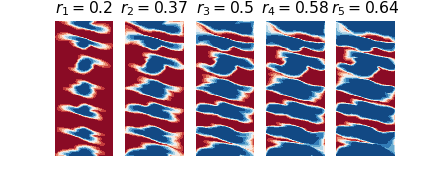

In [16]:
for level in level_dict.keys():
    print(f'level: {level}, grid: {level_dict[level]}')
    env = env_train_dict[level]
    actions_base = np.ones((env.ressim_params.terminal_step, env.action_space.shape[0]) )
    before = time()
    states, actions, rewards = eval_actions(env, actions_base)
    print(f'simulation time: {round(time()-before)} seconds')
    fig = plot_s_snapshots(states, actions, rewards, show_wells=False, figsize_scale=2) 
    fig.show()

constant permeability environment
simulation time: 1 seconds


<IPython.core.display.Javascript object>


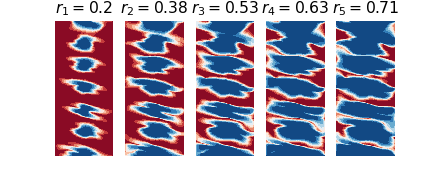

In [17]:
print('constant permeability environment')
env = env_ck
actions_base = np.ones((env.ressim_params.terminal_step, env.action_space.shape[0]) )
before = time()
states, actions, rewards = eval_actions(env, actions_base)
print(f'simulation time: {round(time()-before)} seconds')
fig = plot_s_snapshots(states, actions, rewards, show_wells=False, figsize_scale=2) 
fig.show()

# generate and gather multigrid environement data

In [18]:
actions_ = np.ones((env_train_dict[1].ressim_params.terminal_step,env_train_dict[1].ressim_params.action_space.shape[0]))
seeds = [1,2,3]
levels = list(range(1,len(level_dict)+1))
titles = ['level 1','level 2','level 3', 'level 4']
rs = []
ks = []
ss = []
for seed in seeds:
    rs_seed = []
    ks_seed = []
    ss_seed = []
    for level in levels:
        env_train_dict[level].seed(seed)
        states, actions, rewards = eval_actions(env_train_dict[level], actions_)
        rs_seed.append(rewards)
        ks_seed.append( np.log(env_train_dict[level].k_load) )
        ss_seed.append(states)
    rs.append(rs_seed)
    ks.append(ks_seed)
    ss.append(ss_seed)

# compare permeability plots

<IPython.core.display.Javascript object>


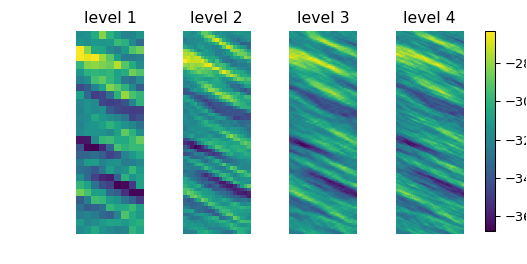

<IPython.core.display.Javascript object>


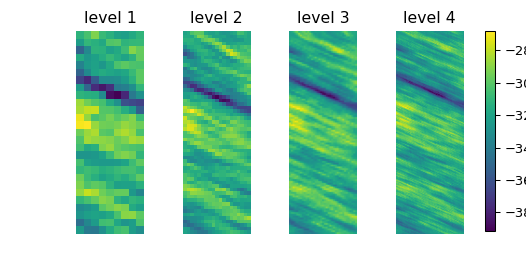

<IPython.core.display.Javascript object>


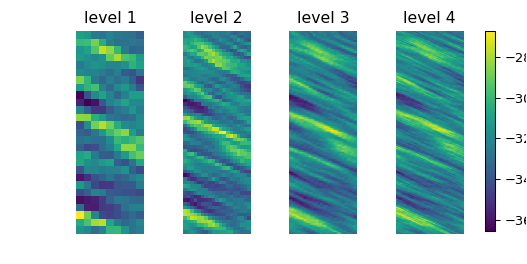

In [19]:
for seed in seeds:
    fig, axs = plt.subplots(1,len(levels),figsize=(1.5*len(levels),3) )
    for i,ax in enumerate(axs):
        ax.axis('off')
        im = ax.imshow(ks[seed-1][i], origin='lower')
        ax.set_title(titles[i])
    cbar_ax = fig.add_axes([0.92, 0.12, 0.02, 0.76])
    fig.colorbar(im, cax=cbar_ax, orientation="vertical") 
    fig.show()

# compare saturations plots

<IPython.core.display.Javascript object>


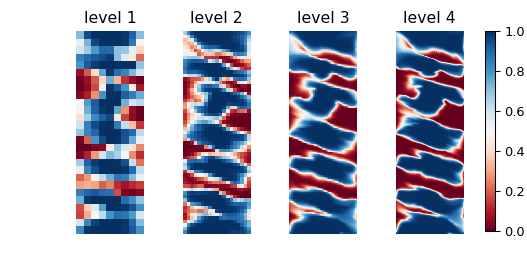

<IPython.core.display.Javascript object>


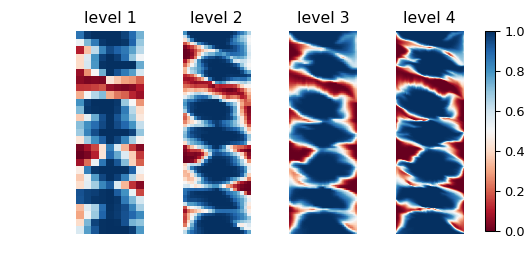

<IPython.core.display.Javascript object>


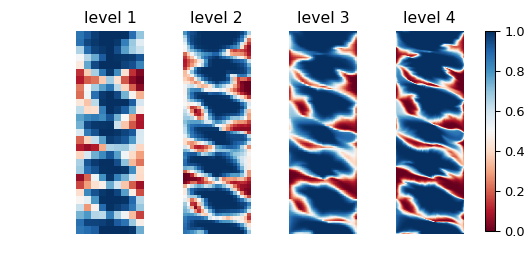

In [20]:
for seed in seeds:
    fig, axs = plt.subplots(1,len(levels),figsize=(1.5*len(levels),3) )
    for i,ax in enumerate(axs):
        ax.axis('off')
        im = ax.imshow(ss[seed-1][i][-1] , origin='lower', cmap='RdBu', vmin=0, vmax=1)
        ax.set_title(titles[i])
    cbar_ax = fig.add_axes([0.92, 0.12, 0.02, 0.76])
    fig.colorbar(im, cax=cbar_ax, orientation="vertical") 
    fig.show()

# compare computational cost and variance

In [21]:
samples = 100

ts, rs = [], []
for seed in trange(samples):
    ts_seed, rs_seed = [], []
    for level in levels:
        env_train_dict[level].seed(seed)
        start_time = time()
        states, actions, rewards = eval_actions(env_train_dict[level], actions_)
        t = time() - start_time
        ts_seed.append(t)
        rs_seed.append(sum(rewards))
    ts.append(ts_seed)
    rs.append(rs_seed)

100%|██████████| 100/100 [02:59<00:00,  1.80s/it]


<IPython.core.display.Javascript object>


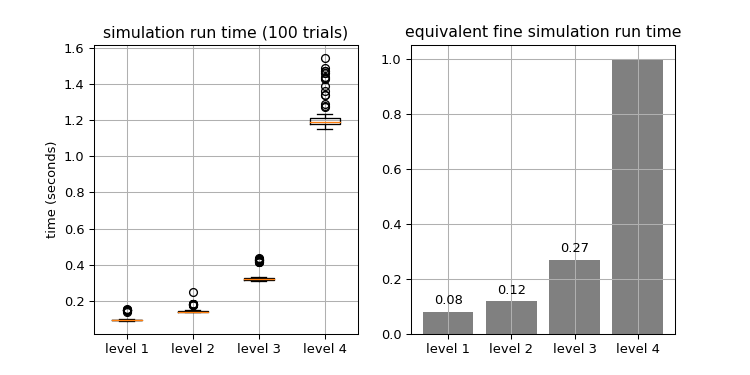

[0.08 0.12 0.27 1.  ]


In [22]:
ts = np.array(ts)
fig,axs = plt.subplots(1,2,figsize=(8,4))
axs[0].boxplot(ts)
axs[0].set_xticklabels(titles)
axs[0].grid('on')
axs[0].set_ylabel('time (seconds)')
axs[0].set_title('simulation run time (100 trials)')

avg_t = ts.mean(axis=0)
avg_t = avg_t/avg_t[-1]
print(np.around(avg_t,2))
axs[1].bar(titles, avg_t, color='gray', width=0.8 )
axs[1].grid('on')
axs[1].set_title('equivalent fine simulation run time')
for i,t in enumerate(avg_t[:-1]):
    axs[1].text(i,t+0.04,str(round(t,2)),
            horizontalalignment='center',
            verticalalignment='center')
fig.show()

<IPython.core.display.Javascript object>


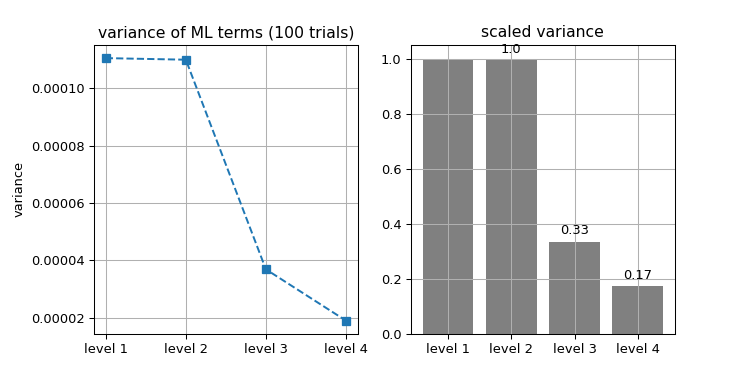

In [23]:
ml_data = []
for rewards in rs:
    ml_terms = []
    for i,r in enumerate(rewards):
        if i==0:
            ml_terms.append(r)
        else:
            ml_terms.append(r-rewards[i-1])
    ml_data.append(ml_terms)
ml_data = np.array(ml_data)

v_scale = np.var(ml_data[:,0])
var, scaled_var = [], []
for i in range(4):
    var.append( np.var(ml_data[:,i]) )
    scaled_var.append( np.var(ml_data[:,i]) / v_scale )
    
    
fig,axs = plt.subplots(1,2,figsize=(8,4))
axs[0].plot(titles, var, 's--')
axs[0].grid('on')
axs[0].set_ylabel('variance')
axs[0].set_title('variance of ML terms (100 trials)')

axs[1].bar(titles, scaled_var, color='gray', width=0.8 )
axs[1].grid('on')
axs[1].set_title('scaled variance')
for i,t in enumerate(scaled_var[1:]):
    axs[1].text(i+1,t+0.04,str(round(t,2)),
            horizontalalignment='center',
            verticalalignment='center')
fig.show()

In [24]:
for n_levels in range(2,5):
    t_ = np.array(avg_t[-n_levels:])
    v_ = np.hstack(([1.0], scaled_var[-(n_levels-1):]))
    t_[-(n_levels-1):] = t_[-(n_levels-1):] + t_[:(n_levels-1)]
    mlmc_cost = np.sum( np.sqrt(t_*v_) )**2
    mc_cost = v_[0]*t_[-1]
    print(f'levels: {n_levels}, mlmc_cost: {mlmc_cost}, mc_cost: {mc_cost}')

levels: 2, mlmc_cost: 0.9737259505470197, mc_cost: 1.269789586541485
levels: 3, mlmc_cost: 1.36732344163708, mc_cost: 1.269789586541485
levels: 4, mlmc_cost: 2.418722494221483, mc_cost: 1.269789586541485
